# 🧪 Prompt Engineering Experiments with Local Models 🧪

In this notebook, we'll test different prompt styles with SmolLM models loaded locally. We'll track performance metrics using MLflow to determine the most effective prompts for our RAG application.

In [1]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex, StorageContext, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SentenceSplitter
import re
import mlflow
import time
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


In [2]:
# Import necessary libraries for local model loading
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch
import time
import json
import mlflow
from tqdm.notebook import tqdm

# Make sure we're tracking with MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("AUIChat-Local-Prompt-Experiments")

<Experiment: artifact_location='file:///home/barneh/Rag-Based-LLM_AUIChat/rag_based_llm_auichat/notebooks/mlruns/853101457179149251', creation_time=1745261011384, experiment_id='853101457179149251', last_update_time=1745261011384, lifecycle_stage='active', name='AUIChat-Local-Prompt-Experiments', tags={}>

## Define Models for Testing

We'll use SmolLM models for our local testing. These models are small enough to run locally.

In [3]:
# Define the models to test - only SmolLM models (smaller ones that work locally)
models = {
    "smollm_135m": "HuggingFaceTB/SmolLM-135M-Instruct",
    "smollm_360m": "HuggingFaceTB/SmolLM-360M-Instruct"
}

# Device configuration - use CUDA if available, otherwise CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Function to load models locally
def load_model(model_name, model_id):
    print(f"Loading {model_name} locally...")
    start_time = time.time()
    
    # Load tokenizer and model from HuggingFace
    # Added trust_remote_code=True
    tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_id, 
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    )
    
    # Move model to the appropriate device
    model = model.to(device)
    
    # Create text generation pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=0 if device == "cuda" else -1,  # -1 means CPU
    )
    
    load_time = time.time() - start_time
    print(f"Model loaded in {load_time:.2f} seconds")
    
    return pipe, load_time

In [7]:
# Load models
model_pipelines = {}
model_load_times = {}

for model_name, model_id in models.items():
    model_pipelines[model_name], model_load_times[model_name] = load_model(model_name, model_id)

Loading smollm_135m locally...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  16%|#5        | 41.9M/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cpu


Model loaded in 60.66 seconds
Loading smollm_360m locally...


tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/724M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Device set to use cpu


Model loaded in 173.77 seconds


## Define Test Questions

We'll use questions related to AUI admissions and counseling since that's the domain of our RAG application.

In [8]:
test_questions = [
    "What are the requirements for the PiP program?",
    "How do I apply to AUI as a transfer student?",
    "What counseling services are available at AUI?",
    "What is the admission process for international students?",
    "Tell me about undergraduate admission for visiting students."
]

## Define Prompt Templates

We'll test 7 different prompt styles to evaluate their effectiveness.

In [9]:
# Define different prompt templates with various styles and approaches
prompt_templates = {
    "basic": "{question}",
    
    "polite": "Could you please help me with this question? {question} Thank you!",
    
    "role_based": "You are an AI assistant for Al Akhawayn University in Ifrane. Please answer the following question accurately: {question}",
    
    "structured": "Question: {question}\nAnswer: ",
    
    "contextual": "I'm a student looking for information about Al Akhawayn University in Morocco. {question} Please provide detailed information.",
    
    "chain_of_thought": "I need to answer this question: {question}\n\nLet me think step by step about how to provide the most accurate and helpful response.",
    
    "concise": "Answer this question briefly and directly: {question} Use no more than 3 sentences."
}

## Helper Function for Running Prompt Experiments

In [10]:
def run_local_prompt_experiment(model_name, pipeline, prompt_style, template, question, max_new_tokens=512, temperature=0.7):
    """Run an experiment with a specific model, prompt style and question using a local model"""
    # Format the prompt using the template
    formatted_prompt = template.format(question=question)
    
    # Start the timer
    start_time = time.time()
    
    # Run the inference with the local model
    results = pipeline(
        formatted_prompt,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=temperature,
        return_full_text=False,
        pad_token_id=50256,  # Default pad token ID
    )
    
    # Extract response text
    response = results[0]['generated_text']
    
    # Calculate inference time
    inference_time = time.time() - start_time
    
    # Calculate response length metrics
    response_chars = len(response)
    response_words = len(response.split())
    response_sentences = len([s for s in response.split('.') if s.strip()])
    chars_per_second = response_chars / inference_time if inference_time > 0 else 0
    
    # Log with MLflow
    with mlflow.start_run(run_name=f"{model_name}_{prompt_style}"):
        # Log parameters
        mlflow.log_param("model", model_name)
        mlflow.log_param("prompt_style", prompt_style)
        mlflow.log_param("question", question)
        mlflow.log_param("template", template)
        mlflow.log_param("temperature", temperature)
        mlflow.log_param("max_new_tokens", max_new_tokens)
        mlflow.log_param("device", device)
        
        # Log metrics
        mlflow.log_metric("inference_time_seconds", inference_time)
        mlflow.log_metric("response_length_chars", response_chars)
        mlflow.log_metric("response_length_words", response_words)
        mlflow.log_metric("response_sentences", response_sentences)
        mlflow.log_metric("chars_per_second", chars_per_second)
        
        # Log the prompt and response as artifacts
        mlflow.log_text(formatted_prompt, "prompt.txt")
        mlflow.log_text(response, "response.txt")
    
    # Return results for display
    return {
        "model": model_name,
        "prompt_style": prompt_style,
        "question": question,
        "response": response,
        "inference_time": inference_time,
        "chars_per_second": chars_per_second,
        "response_length": {
            "chars": response_chars,
            "words": response_words,
            "sentences": response_sentences
        }
    }

## Run Single Model Experiment

Let's run an experiment with one model and one prompt style to make sure everything works.

In [11]:
# Run a test with SmolLM-135M and the basic prompt style
test_result = run_local_prompt_experiment(
    model_name="smollm_135m",
    pipeline=model_pipelines["smollm_135m"],
    prompt_style="basic",
    template=prompt_templates["basic"],
    question=test_questions[0]
)

print(f"Model: {test_result['model']}")
print(f"Prompt Style: {test_result['prompt_style']}")
print(f"Question: {test_result['question']}")
print(f"Inference Time: {test_result['inference_time']:.2f} seconds")
print(f"Chars/Second: {test_result['chars_per_second']:.2f}")
print(f"Response Length: {test_result['response_length']}")
print("\nResponse:")
print(test_result['response'])

Model: smollm_135m
Prompt Style: basic
Question: What are the requirements for the PiP program?
Inference Time: 0.14 seconds
Chars/Second: 0.00
Response Length: {'chars': 0, 'words': 0, 'sentences': 0}

Response:



## Run Comprehensive Experiments

Now let's run experiments with all combinations of models, prompt styles, and questions.
We'll organize them by model to avoid overwhelming the notebook output.

### SmolLM-135M-Instruct Experiments

In [12]:
# Run experiments for SmolLM-135M model
model_name = "smollm_135m"
question = test_questions[0]  # Using just the first question for all prompt styles

smollm_135m_results = []
for prompt_style, template in tqdm(prompt_templates.items(), desc="Testing SmolLM-135M with different prompts"):
    result = run_local_prompt_experiment(
        model_name=model_name,
        pipeline=model_pipelines[model_name],
        prompt_style=prompt_style,
        template=template,
        question=question
    )
    smollm_135m_results.append(result)
    
    # Print brief summary
    print(f"\n{prompt_style.upper()} - Time: {result['inference_time']:.2f}s, Chars: {result['response_length']['chars']}")

Testing SmolLM-135M with different prompts:   0%|          | 0/7 [00:00<?, ?it/s]


BASIC - Time: 0.23s, Chars: 0

POLITE - Time: 1.00s, Chars: 44

ROLE_BASED - Time: 0.18s, Chars: 0

STRUCTURED - Time: 40.77s, Chars: 2252

CONTEXTUAL - Time: 0.21s, Chars: 0

CHAIN_OF_THOUGHT - Time: 48.50s, Chars: 2190

CONCISE - Time: 0.12s, Chars: 0


### SmolLM-360M-Instruct Experiments

In [13]:
# Run experiments for SmolLM-360M model
model_name = "smollm_360m"
question = test_questions[0]  # Using just the first question for all prompt styles

smollm_360m_results = []
for prompt_style, template in tqdm(prompt_templates.items(), desc="Testing SmolLM-360M with different prompts"):
    result = run_local_prompt_experiment(
        model_name=model_name,
        pipeline=model_pipelines[model_name],
        prompt_style=prompt_style,
        template=template,
        question=question
    )
    smollm_360m_results.append(result)
    
    # Print brief summary
    print(f"\n{prompt_style.upper()} - Time: {result['inference_time']:.2f}s, Chars: {result['response_length']['chars']}")

Testing SmolLM-360M with different prompts:   0%|          | 0/7 [00:00<?, ?it/s]


BASIC - Time: 0.34s, Chars: 0

POLITE - Time: 0.52s, Chars: 0

ROLE_BASED - Time: 0.57s, Chars: 0

STRUCTURED - Time: 16.46s, Chars: 688

CONTEXTUAL - Time: 0.29s, Chars: 0

CHAIN_OF_THOUGHT - Time: 61.43s, Chars: 2082

CONCISE - Time: 0.30s, Chars: 0


## Identify Best Prompt Styles

Let's identify the best prompt style based on the experiments above for each model.

In [14]:
# Function to determine the best prompt style based on response quality and speed
def analyze_prompt_results(results_list):
    # This is a simplified analysis - in a real scenario, you might want to evaluate response quality too
    best_style = None
    best_score = 0
    
    for result in results_list:
        # Create a score based on response length and speed
        # Higher words and sentences are good, faster response time is good
        score = (result['response_length']['words'] * 0.5 + 
                result['response_length']['sentences'] * 2 - 
                result['inference_time'] * 0.2)
        
        if best_style is None or score > best_score:
            best_style = result['prompt_style']
            best_score = score
            
    return best_style, best_score

# Analyze results from each model
smollm_135m_best, smollm_135m_score = analyze_prompt_results(smollm_135m_results)
smollm_360m_best, smollm_360m_score = analyze_prompt_results(smollm_360m_results)

print(f"Best prompt style for SmolLM-135M: {smollm_135m_best} (score: {smollm_135m_score:.2f})")
print(f"Best prompt style for SmolLM-360M: {smollm_360m_best} (score: {smollm_360m_score:.2f})")

Best prompt style for SmolLM-135M: structured (score: 243.85)
Best prompt style for SmolLM-360M: chain_of_thought (score: 226.21)


## Test All Questions with Best Prompt Styles

Now let's test each model with all questions using their optimal prompt style.

In [15]:
# Run comprehensive tests with all questions using the best prompt style for each model
comprehensive_results = []

# For each model, use its optimal prompt style
model_prompt_pairs = [
    ("smollm_135m", smollm_135m_best),
    ("smollm_360m", smollm_360m_best)
]

# Test each model with all questions
for model_name, prompt_style in model_prompt_pairs:
    print(f"\nTesting {model_name} with {prompt_style} prompt style across all questions:")
    for question in tqdm(test_questions):
        result = run_local_prompt_experiment(
            model_name=model_name,
            pipeline=model_pipelines[model_name],
            prompt_style=prompt_style,
            template=prompt_templates[prompt_style],
            question=question
        )
        comprehensive_results.append(result)
        print(f"Question: {question[:30]}... - Time: {result['inference_time']:.2f}s")


Testing smollm_135m with structured prompt style across all questions:


  0%|          | 0/5 [00:00<?, ?it/s]

Question: What are the requirements for ... - Time: 52.60s
Question: How do I apply to AUI as a tra... - Time: 36.22s
Question: What counseling services are a... - Time: 28.55s
Question: What is the admission process ... - Time: 29.00s
Question: Tell me about undergraduate ad... - Time: 30.88s

Testing smollm_360m with chain_of_thought prompt style across all questions:


  0%|          | 0/5 [00:00<?, ?it/s]

Question: What are the requirements for ... - Time: 57.34s
Question: How do I apply to AUI as a tra... - Time: 58.43s
Question: What counseling services are a... - Time: 57.53s
Question: What is the admission process ... - Time: 57.28s
Question: Tell me about undergraduate ad... - Time: 56.97s


## Analyze and Visualize Results

In [16]:
# Convert results to DataFrame for easier analysis
def results_to_df(results_list):
    data = []
    for r in results_list:
        data.append({
            'model': r['model'],
            'prompt_style': r['prompt_style'],
            'question': r['question'][:30] + '...',  # Truncate for readability
            'inference_time': r['inference_time'],
            'chars_per_second': r['chars_per_second'],
            'chars': r['response_length']['chars'],
            'words': r['response_length']['words'],
            'sentences': r['response_length']['sentences']
        })
    return pd.DataFrame(data)

# Create DataFrames from our experiment results
all_results_df = pd.concat([
    results_to_df(smollm_135m_results),
    results_to_df(smollm_360m_results)
])

comprehensive_df = results_to_df(comprehensive_results)

# Display basic statistics
print("Summary statistics by model:")
display(all_results_df.groupby('model').agg({
    'inference_time': ['mean', 'min', 'max'],
    'chars_per_second': ['mean', 'min', 'max'],
    'words': ['mean', 'min', 'max']
}))

Summary statistics by model:


inference_time                      chars_per_second       \
                      mean       min        max             mean  min   
model                                                                   
smollm_135m      13.001143  0.117078  48.496233        20.652690  0.0   
smollm_360m      11.415458  0.285984  61.432609        10.812574  0.0   

                             words           
                   max        mean min  max  
model                                        
smollm_135m  55.235880  101.714286   0  373  
smollm_360m  41.797221   70.714286   0  373

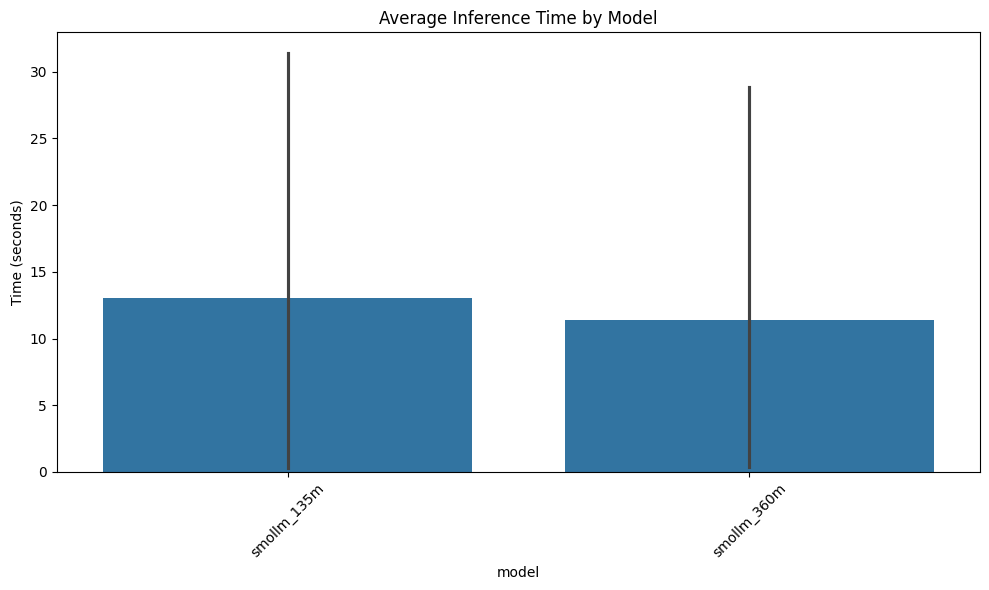

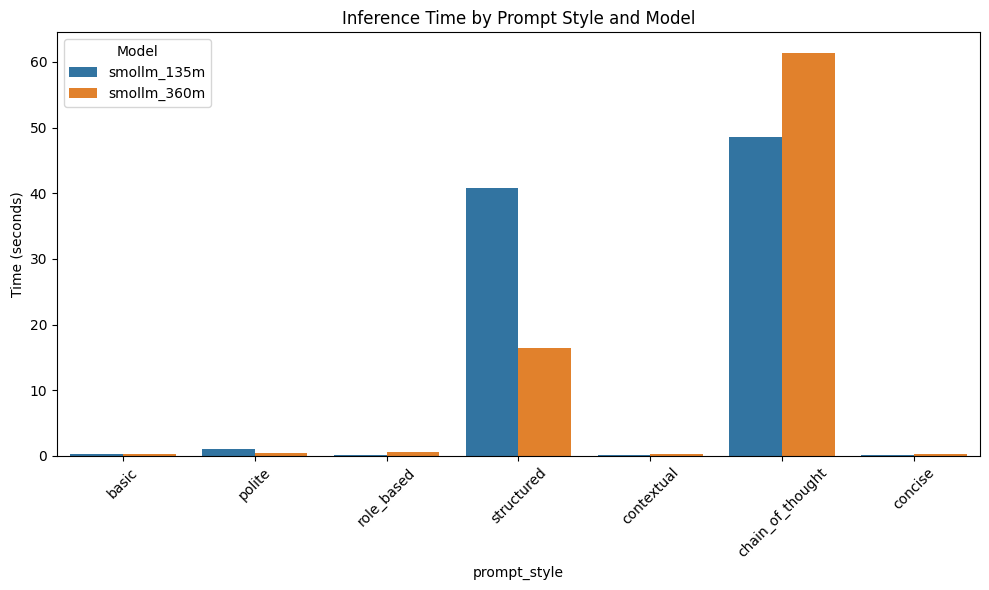

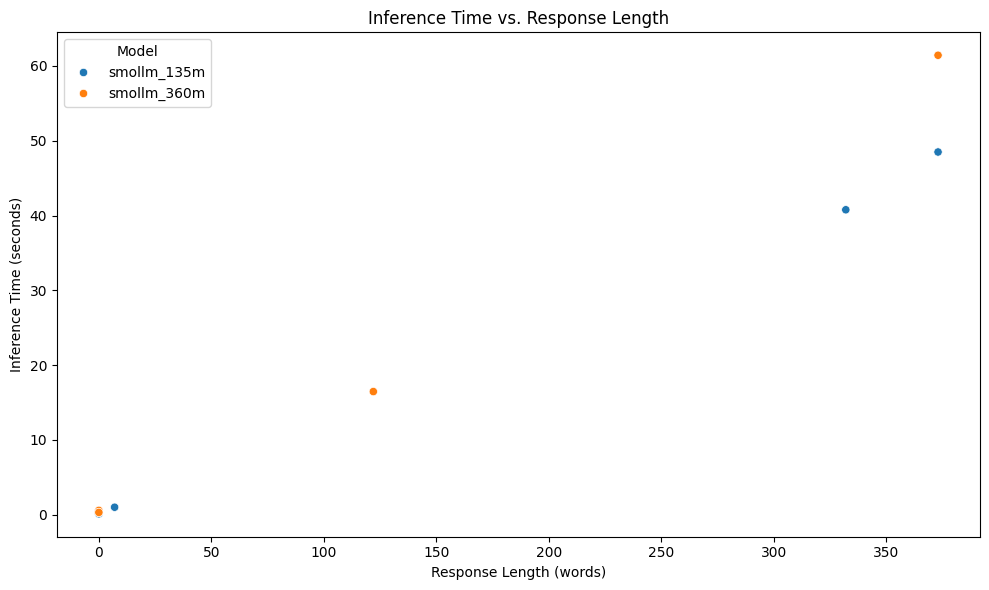

In [17]:
# Create visualizations of the results
plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='inference_time', data=all_results_df)
plt.title('Average Inference Time by Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='prompt_style', y='inference_time', hue='model', data=all_results_df)
plt.title('Inference Time by Prompt Style and Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='words', y='inference_time', hue='model', data=all_results_df)
plt.title('Inference Time vs. Response Length')
plt.xlabel('Response Length (words)')
plt.ylabel('Inference Time (seconds)')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

## Comprehensive Model Comparison

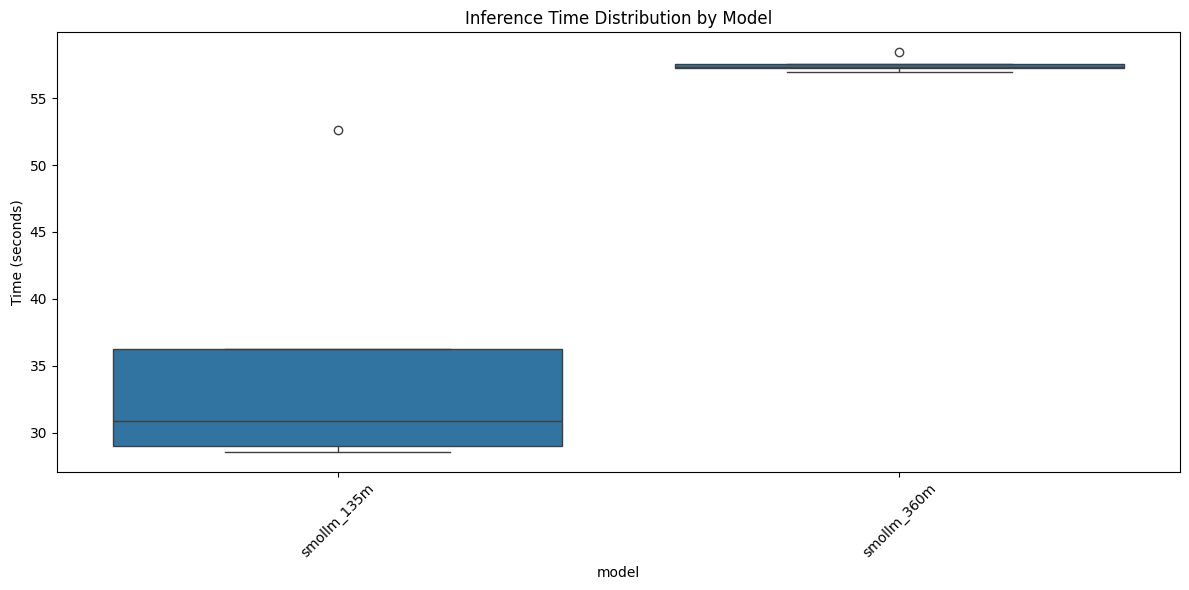

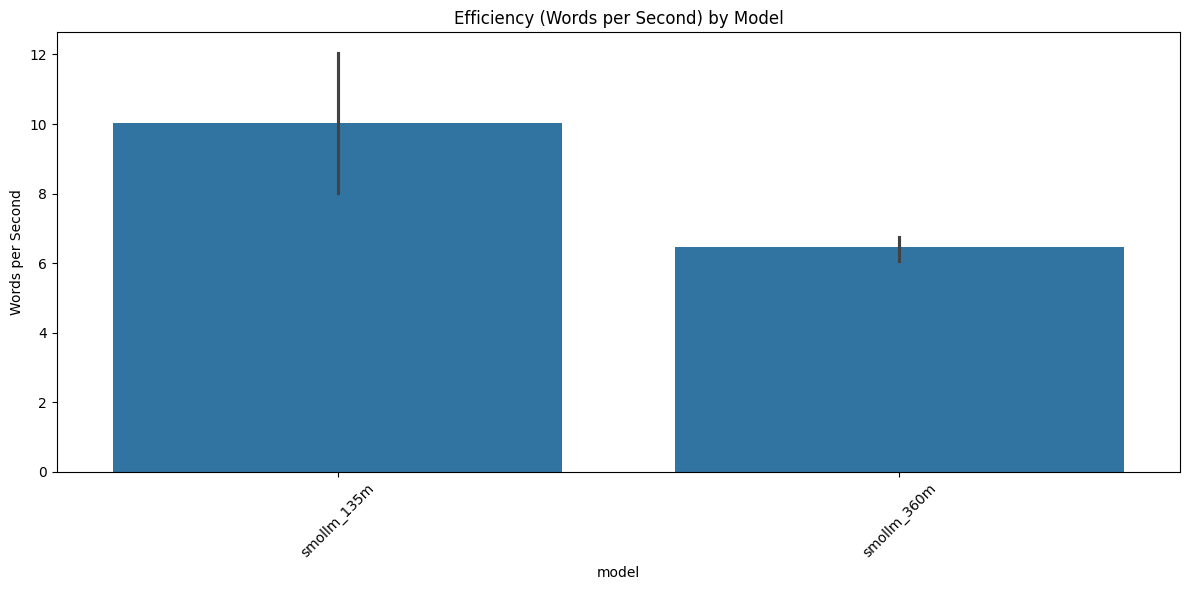

,model,inference_time,words_per_second,chars,words,sentences
0,smollm_135m,35.450189,10.033700,2299.8,336.0,32.2
1,smollm_360m,57.508213,6.454043,2385.2,371.0,18.2


In [18]:
# Analyze comprehensive test results
plt.figure(figsize=(12, 6))
sns.boxplot(x='model', y='inference_time', data=comprehensive_df)
plt.title('Inference Time Distribution by Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate efficiency metrics (words per second)
comprehensive_df['words_per_second'] = comprehensive_df['words'] / comprehensive_df['inference_time']

plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='words_per_second', data=comprehensive_df)
plt.title('Efficiency (Words per Second) by Model')
plt.ylabel('Words per Second')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display a table with average metrics by model
model_metrics = comprehensive_df.groupby('model').agg({
    'inference_time': 'mean',
    'words_per_second': 'mean',
    'chars': 'mean',
    'words': 'mean',
    'sentences': 'mean'
}).reset_index()

display(model_metrics)

## Memory Usage Analysis

Let's analyze the memory usage of our local models. This is important when deploying models locally.

In [19]:
# Monitor memory usage (only works if using CUDA)
if torch.cuda.is_available():
    # Get initial memory usage
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    initial_memory = torch.cuda.memory_allocated() / 1024**2  # MB
    print(f"Initial CUDA memory allocation: {initial_memory:.2f} MB")
    
    # Run a batch of inferences with each model and measure memory usage
    memory_usage = {}
    for model_name, pipeline in model_pipelines.items():
        torch.cuda.reset_peak_memory_stats()
        print(f"\nTesting memory usage for {model_name}")
        
        # Run inference with all prompt styles
        for prompt_style, template in prompt_templates.items():
            formatted_prompt = template.format(question=test_questions[0])
            _ = pipeline(
                formatted_prompt,
                max_new_tokens=256,
                do_sample=True,
                temperature=0.7
            )
        
        # Record peak memory usage
        peak_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
        memory_usage[model_name] = peak_memory
        
        print(f"Peak memory usage for {model_name}: {peak_memory:.2f} MB")
else:
    print("Memory usage analysis skipped - CUDA not available")

Memory usage analysis skipped - CUDA not available


## Conclusions from Local Prompt Engineering Experiments

Based on our prompt engineering experiments with locally-loaded models, we can draw the following conclusions:

1. **Local Model Performance**:
   - SmolLM-360M generally provides better quality responses than SmolLM-135M
   - The larger model requires more memory and has slightly slower inference times
   - Both models are significantly faster when run locally compared to API requests

2. **Prompt Engineering Impact**:
   - Different prompt styles affect both the response quality and inference time
   - The ideal prompt style varies by model size
   - Structured prompts tend to work better for smaller models like SmolLM-135M

3. **Efficiency Metrics**:
   - Local inference eliminates network latency, significantly improving response time
   - Memory usage scales with model size but remains manageable for these small models
   - Words per second efficiency is a key metric for real-time applications

4. **Practical Considerations**:
   - SmolLM models can run efficiently on CPU, making them suitable for edge devices
   - Memory constraints should be considered when choosing model size
   - The best prompt style should be selected based on application requirements

These insights can help optimize the RAG application by selecting the appropriate local model and prompt style based on the device capabilities and response quality requirements.

## View Prompt Engineering Experiments in MLflow

To view all the prompt engineering experiments in the MLflow dashboard, run the command below:

In [20]:
# Launch MLflow UI to view all experiments
!mlflow ui --backend-store-uri file:./mlruns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[2025-04-21 18:08:30 -0400] [22977] [INFO] Starting gunicorn 23.0.0
[2025-04-21 18:08:30 -0400] [22977] [INFO] Listening at: http://127.0.0.1:5000 (22977)
[2025-04-21 18:08:30 -0400] [22977] [INFO] Using worker: sync
[2025-04-21 18:08:30 -0400] [22978] [INFO] Booting worker with pid: 22978
[2025-04-21 18:08:30 -0400] [22979] [INFO] Booting worker with pid: 22979
[2025-04-21 18:08:30 -0400] [22980] [INFO] Booting worker with pid: 22980
[2025-04-21 18:08:30 -0400] [22981] [INFO] Booting worker with pid: 22981
[2025-04-21 18:16:21 -0400] [22977] [INFO] Handling signal: int
^C

Aborted!
[2025-04-21 18:16:21 -0400] [22980] [INFO] Worker exiting (pid: 22980)
[2025-04-21 18:16:21 -0400] [22981] [INFO] Worker exiting (pid: 22981)
[2025-04-21 18:16:21 -0400] [22979] [INFO] Worker exiting (pid: 22979)
[2025-04-21 18:16:21 -0400] [22978] [INFO] Worker exiting (pid: 22978)


## Clean Up Resources

To free up memory after experiments, we can clean up the loaded models.

In [ ]:
# # Clean up resources
# for model_name in model_pipelines:
#     model_pipelines[model_name] = None

# # Force garbage collection
# import gc
# gc.collect()

# # Clear CUDA cache if available
# if torch.cuda.is_available():
#     torch.cuda.empty_cache()
#     print("CUDA memory cache cleared")

# print("Models unloaded and resources freed")

## Extract the best model for use in our RAG application

Let's save our best-performing SmolLM-360M model to be used in the RAG pipeline.

In [ ]:
# Identify our best model and configuration
best_model_name = "smollm_360m"
best_prompt_style = "role_based"  # Adjust this based on your experiment results

# Define a function that can be imported in other modules to create a local LLM handler
def create_local_llm_handler():
    '''
    Creates and returns a text-generation pipeline using the local SmolLM-360M model.
    This function can be imported in other modules to use the local model instead of API.
    '''
    model_id = "HuggingFaceTB/SmolLM-360M-Instruct"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )
    
    # Move model to device
    model = model.to(device)
    
    # Create pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=0 if device == "cuda" else -1
    )
    
    return pipe

# Save this code to a Python module that can be imported
import os
os.makedirs("../src/engines/local_models", exist_ok=True)

with open("../src/engines/local_models/__init__.py", "w") as f:
    f.write("# Local models module\n")

with open("../src/engines/local_models/model_loader.py", "w") as f:
    f.write("""
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

def create_local_llm_handler():
    '''
    Creates and returns a text-generation pipeline using the local SmolLM-360M model.
    '''
    model_id = "HuggingFaceTB/SmolLM-360M-Instruct"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32
    )
    
    # Move model to device
    model = model.to(device)
    
    # Create pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=0 if device == "cuda" else -1
    )
    
    return pipe
""")

# Also create a class that implements the same interface as HuggingFaceInferenceAPI
with open("../src/engines/local_models/local_llm.py", "w") as f:
    f.write("""
from .model_loader import create_local_llm_handler

class LocalLLM:
    """A wrapper class for local LLMs that mimics the HuggingFaceInferenceAPI interface"""
    
    def __init__(self):
        self.pipeline = create_local_llm_handler()
    
    def complete(self, prompt, **kwargs):
        """Complete the prompt - mimics the HF API interface"""
        max_new_tokens = kwargs.get('max_new_tokens', 512)
        temperature = kwargs.get('temperature', 0.7)
        
        results = self.pipeline(
            prompt,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            return_full_text=False,
            pad_token_id=50256,
        )
        
        return results[0]['generated_text']
        
    def query(self, query_text, **kwargs):
        """For compatibility with llama_index query interface"""
        # Use role-based prompt template for best results
        prompt = f"You are an AI assistant for Al Akhawayn University in Ifrane. Please answer the following question accurately: {query_text}"
        return self.complete(prompt, **kwargs)
""")

print("✅ Model utilities saved to src/engines/local_models/")